<a href="https://colab.research.google.com/github/Gunanana/AIML/blob/main/Models/binaryClassificationMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Data set and Prepare


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Fetch the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
# Break the data set into X and y
# mnist is a dict of dataframes
mnist.target = mnist.target.astype(np.int8)
X = mnist['data']
y = mnist['target']

In [4]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [5]:
# Break dataset into testing and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=60000, random_state=42)

# convert y to boolean series
y_train, y_test = (y_train==5), (y_test==5)

### Data Visualisation

In [6]:
index = 440
print('Number: ', y[index])

Number:  0


In [7]:
digit = X.iloc[index]
digit = digit.to_numpy().reshape(28,28)
print(digit.shape)

(28, 28)


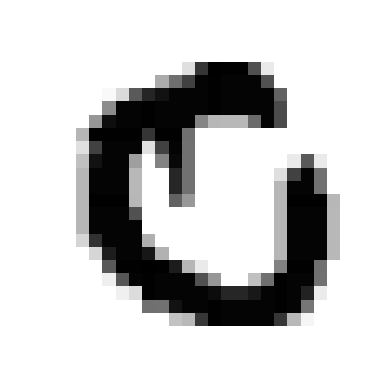

In [8]:
plt.imshow(digit, cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

# SGDClassifier

In [9]:
# Create and train your Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42,)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [10]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(sgd_clf, X_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(score)

[0.9629  0.96775 0.96435]


### Dumb Classifier


In [11]:
from sklearn.base import BaseEstimator

class DumbClassifier(BaseEstimator):
  def fit(self, X, y=None):
    return
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [12]:
dumb_clf = DumbClassifier()
dumb_clf.fit(X_train, y_train)

In [13]:
cvscore = cross_val_score(dumb_clf, X_train, y_train, cv=3, scoring='accuracy')
print(cvscore)

[0.9119  0.90875 0.91055]


### Confusion Matrix

In [14]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_preds = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

In [15]:
cm = confusion_matrix(y_train, y_preds)
print(cm)

[[54103   521]
 [ 1579  3797]]


### Precision, Recall and F1 Score

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(y_train, y_preds)
recall = recall_score(y_train, y_preds)

print('Precision: ', precision)
print('Recall: ', recall)

Precision:  0.8793422880963409
Recall:  0.7062872023809523


In [17]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train, y_preds)
print('F1 score: ',f1 )

F1 score:  0.783371157416959


### Decision Scores

In [72]:
dscore = sgd_clf.decision_function(X_train)

# OR

dscore = cross_val_predict(sgd_clf, X_train, y_train, cv=4, method='decision_function')

In [19]:
print(type(dscore))
print(dscore[:20])

<class 'numpy.ndarray'>
[-14144.50606206  -7842.57037663  -4672.65965862  -7308.7563866
  -9980.44966839 -13746.0481897   -7085.56177395 -12489.55028269
  -4842.67542597  -5663.64224638  -4933.86438967  -8211.84244108
  -7756.49956276 -14684.73577271  -8339.4123049   -8088.21006203
  -7095.09995565 -10878.88934159    968.44187865 -11519.2591816 ]


In [20]:
threshold = -100000
print((dscore > threshold)[:20])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


### Precision Recall Curve

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, dscore)

In [23]:
print(f'Precisions: {precisions}')
print(f'Recalls: {recalls}')
print(f'Thresholds: {thresholds}')

Precisions: [0.0896     0.08960149 0.08960299 ... 1.         1.         1.        ]
Recalls: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.72023810e-04
 1.86011905e-04 0.00000000e+00]
Thresholds: [-76158.7148353  -69727.94570913 -68588.54175096 ...  15602.47758332
  16022.44776987  17238.21107438]


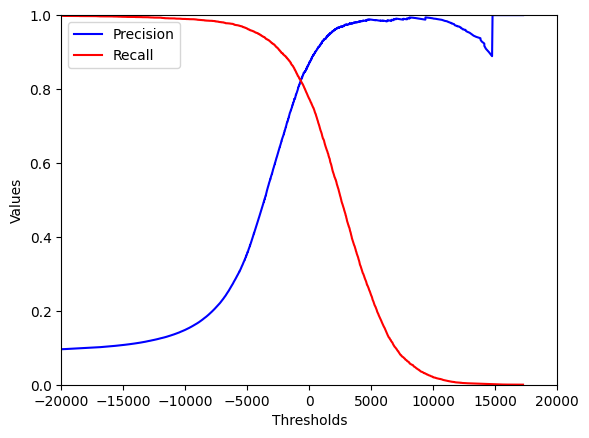

In [31]:
# Precision, Recall vs Threshold Curve
plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')

plt.xlabel('Thresholds')
plt.ylabel('Values')

plt.xlim([-20000, 20000])
plt.ylim([0,1])

plt.legend()
plt.show()

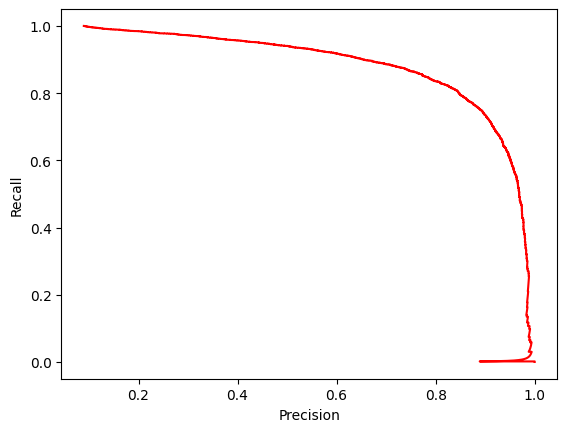

In [34]:
# Plot a curve between recall and precision

plt.plot(precisions, recalls, 'r-')

plt.xlabel('Precision')
plt.ylabel('Recall')

plt.show()

### Finding the threshold with 80% recall and precision

In [39]:
print(recalls>0.8)

[ True  True  True ... False False False]


In [63]:
# Get the index where the first False appears for recall. That index corresponds to the threshold which gives 80% recall and precision
temp_recall_80 = recalls>0.8
threshold_80_index = 0

for i in range(len(temp_recall_80)):
  global threshold_80_index
  if(temp_recall_80[i] == False):
    threshold_80_index = i-1
    break

In [64]:
# Get the threshold which corresponds to 80% recall
threshold_80_percent = thresholds[threshold_80_index]
print(threshold_80_percent)

-342.5821915752627


In [65]:
# Get the predictions for this threshold
dscore_80_recall_precision = dscore > threshold_80_percent

In [66]:
# Verify if this predictions give 80% recall
print(f'Recall: {recall_score(y_train, dscore_80_recall_precision)*100}%')
print(f'Precision: {precision_score(y_train, dscore_80_recall_precision) * 100}%')

Recall: 79.98511904761905%
Precision: 84.77917981072555%


### ROC Curve (Receiver Operating Characteristic)
It’s called that because it originally came from signal detection theory during World War II. The term "receiver" refers to the radar receiver operators who were trying to distinguish signals (aircraft) from noise (other objects like clouds or birds). The characteristic part refers to the curve that plots the trade-off between sensitivity (true positive rate) and false alarm rate (false positive rate) across different thresholds.

So, the ROC curve is used to visualize the performance of a binary classifier by showing how well the model distinguishes between positive and negative classes at different threshold values. The curve plots:

True Positive Rate (TPR) on the Y-axis (also called recall or sensitivity)
False Positive Rate (FPR) on the X-axis (also 1 - specificity)
The curve helps assess how well the classifier separates the two classes, with an ideal curve being close to the top-left corner of the graph.








In [70]:
# ROC curve is plot with FPR vs TPR
from sklearn.metrics import roc_curve

# So first get fpr, tpr
fpr, tpr, thresholds = roc_curve(y_train, dscore)

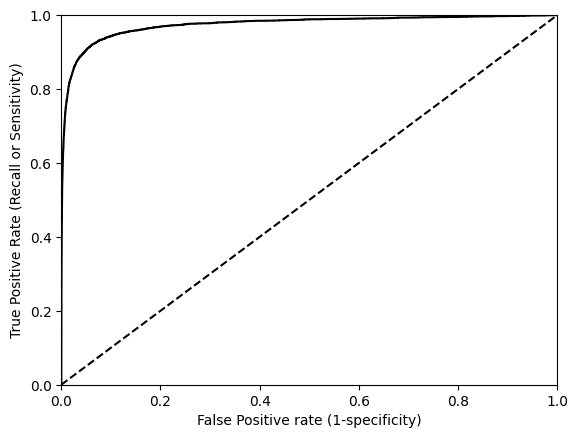

In [75]:
# Plot the ROC curve
plt.plot(fpr, tpr, 'k-')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive rate (1-specificity)')
plt.ylabel('True Positive Rate (Recall or Sensitivity)')

plt.ylim([0,1])
plt.xlim([0,1])


plt.show()

To read the ROC Curve, we use AUC

In [76]:
from sklearn.metrics import roc_auc_score

roc_area_score = roc_auc_score(y_train, dscore)
print(roc_area_score)

0.9562539869423348


### Compare with RandomForestClassifier

In [77]:
# Lets compare this model's roc_auc score to a Random Forest classifier's onces
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

In [83]:
probabilities = cross_val_predict(rf_clf, X_train, y_train, method='predict_proba', cv=3)

In [87]:
rf_score = probabilities[:,1]

In [88]:
fpr, tpr, thresholds = roc_curve(y_train, rf_score)

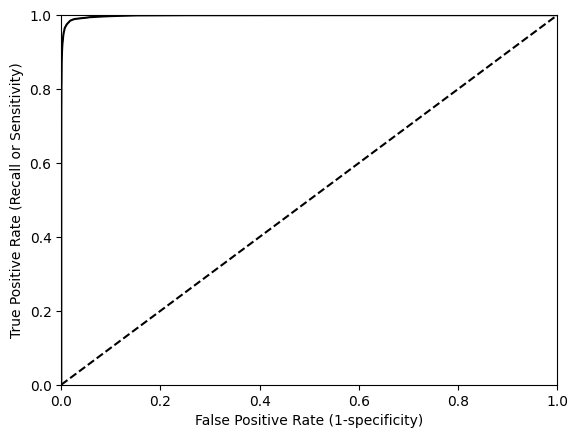

In [89]:
plt.plot(fpr, tpr, 'k-')
plt.plot([0,1], [0,1], 'k--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (Recall or Sensitivity)')

plt.show()

In [90]:
# Get the AUC score

auc_score_rf = roc_auc_score(y_train, rf_score)
print(f'{auc_score_rf*100}%')

99.84563317302747%
